In [39]:
import pandas as pd
import torch
import numpy as np
from d2l import torch as d2l

In [329]:
# 读取数据
train_set = pd.read_csv('/home/zhaizhe/div-into-deeplearning/data/kaggle/HousePriceAdv/train.csv')
test_set = pd.read_csv('/home/zhaizhe/div-into-deeplearning/data/kaggle/HousePriceAdv/test.csv')

all_features = pd.concat((train_set.iloc[:,1:-1], test_set.iloc[:,1:]))
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(lambda x: (x - x.mean()) / (x.std()))
all_features[numeric_features] = all_features[numeric_features].fillna(0)
all_features = pd.get_dummies(all_features, dummy_na=True)
print(all_features.shape)

(2919, 331)


In [41]:
n_train = train_set.shape[0]
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float32)
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float32)
train_labels = torch.tensor(train_set.SalePrice.values.reshape(-1,1), dtype=torch.float32)

In [198]:
def data_loader(feature, label, batch_size):
    indices = np.arange(len(feature))
    np.random.shuffle(indices)
    for i in range(0, len(feature), batch_size):
        right = i + batch_size if i + batch_size < len(feature) else len(feature)
        yield feature[indices[i : right]], label[indices[i : right]]
        

In [81]:
def get_k_fold_data(k, i, X, y):
    # 把数据集拆为k个子集，把第i个子集当作验证集，其他部分放到训练集
    fold_size = len(X) // k
    train_X, train_y = None, None
    for j in range(k):
        idxs = slice(j * fold_size, (j + 1) * fold_size)
        part_X, part_y = X[idxs], y[idxs]
        if i == j:
            valid_X, valid_y = part_X, part_y
        elif train_X is None:
            train_X, train_y = part_X, part_y
        else:
            train_X = torch.cat((train_X, part_X), 0)
            train_y = torch.cat((train_y, part_y), 0)
    return train_X, train_y, valid_X, valid_y

train_X, train_y, valid_X, valid_y = get_k_fold_data(5, 1, train_features, train_labels)

$$\sqrt{\frac{1}{n}\sum_{i=1}^n\left(\log y_i -\log \hat{y}_i\right)^2}.$$

The 0 fold data: 0.143219 0.154284
The 1 fold data: 0.143709 0.136375


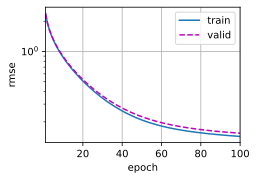

In [317]:
# 定义模型
def linear_reg(W, X, b):
#     print(W.shape, X.shape)
#     return ((X * W).sum() + b)
    return torch.matmul(X, W.reshape(-1, 1)) + b

def l2_penalty(lambd, w):
    return lambd * torch.sum(w.pow(2)) / 2

def loss(y, y_hat):
    return (y - y_hat) ** 2 / 2;


# 定义损失函数，这里有一个重要错误（使用了均方损失），
# 对于房价我们更关心的是百分比差值而不是绝对值差值，因为房子的价格差异很大
def log_rmse(y, y_hat):
    rmse = torch.sqrt(loss(torch.log(y), torch.log(y_hat)).mean())
    return rmse.item()

def sgd(params, lr, batch_size):
    with torch.no_grad():
        for param in params:
            # 注意下 param -= lr * param.grad和param = param - lr * param.grad有巨大区别
            # 一个是复制传值，一个是指针传值
            param -= lr * param.grad / batch_size
            param.grad.zero_()

def init_variables(input_shape):
    W = torch.normal(0, 0.054, size=(1, input_shape), requires_grad=True)
    b = torch.zeros(1, requires_grad=True)
    return W, b

def train(W, b, train_X, train_y, test_X, test_y, epochs, lr,  batch_size, weight_decay):
    train_l, test_l = [], []
    for epoch in range(epochs):
        train_iter = data_loader(train_X, train_y, batch_size)
        for X, y in train_iter:
            y_hat = linear_reg(W, X, b)
            l = loss(y, y_hat) + l2_penalty(weight_decay, W)
            l.sum().backward()
            sgd([W, b], lr, batch_size)
        train_l.append(log_rmse(linear_reg(W, train_X, b), train_y))
        if test_y is not None:
            with torch.no_grad():
                l = log_rmse(linear_reg(W, test_X, b), test_y)
                test_l.append(l)
    return train_l, test_l

def fold_k():
    k, lr, epochs, batch_size, weight_decay = 2, 0.0002, 100, 128, 1
    for i in range(k):
        W, b = init_variables(train_features.shape[1])
        data = get_k_fold_data(k, i, train_features, train_labels)
        train_l, test_l = train(W, b, *data, epochs, lr, batch_size, weight_decay)
        print(f'The {i} fold data: {float(train_l[-1]):f} {float(test_l[-1]):f}')
        if i == 0:
            d2l.plot(list(range(1, epochs + 1)), [train_l, test_l],
                xlabel='epoch', ylabel='rmse', xlim=[1, epochs],
                legend=['train', 'valid'], yscale='log')
    
fold_k()


In [332]:
def train_and_pred():
    k, lr, epochs, batch_size, weight_decay = 2, 0.0002, 100, 128, 1
    W, b = init_variables(train_features.shape[1])
    train(W, b, train_features, train_labels, test_features, None,
                            epochs, lr, batch_size, weight_decay)
    predict_labels = linear_reg(W, test_features, b).detach().numpy()
    test_set['SalePrice'] = pd.Series(predict_labels.reshape(1, -1)[0])
    submission = pd.concat([test_set['Id'], test_set['SalePrice']], axis = 1)
    submission.to_csv('../data/kaggle/HousePriceAdv/submission.csv', index=False)
    print('done')
    
    
train_and_pred()


done


# 总结
和教学课程中不一样的点：
- 数据需要清洗：规范化，补零
- 更关心预测值和真实值的百分比差异，所以用log_rmse表示

重要点
- 初始化模型参数很重要，学习步长很重要